In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, GRU, Dense,Flatten,Dropout,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import mlflow.tensorflow
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

Using TensorFlow backend.


In [26]:
def create_sequences(dataset, in_steps=1, out_steps=1, dropNa=True):
    """Converts time series into a data set for supervised machine learning models"""
    # drop row's which include Nan elements (data preprocessing)
    df = pd.DataFrame(dataset)
    if dropNa:
        df.dropna(inplace=True)
    dataset = df.values
    # create x and y out of dataset
    dataX, dataY = [], []
    for i in range(len(dataset)):
        endIdx = i + in_steps + out_steps
        # stop if reached the end of dataset
        if endIdx > len(dataset):
            break
        dataX.append(dataset[i:endIdx-out_steps, :])
        dataY.append(dataset[endIdx-out_steps:endIdx, :])
    return np.array(dataX), np.array(dataY)

In [215]:
def test_train(datasetsize, testsize, shuffle=True):
    """Returns two dataset to train and test machine learning models"""
    if shuffle:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        np.random.shuffle(idx)
        train_index = idx[ntest:]
        test_index = idx[:ntest]
        return train_index, test_index
    else:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        test_index = idx[datasetsize - ntest:]
        train_index = idx[:datasetsize - ntest]
        return train_index, test_index

In [4]:
def build_model_lstm(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(n_steps,n_feats)))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dropout(0.20))
    model.add(Dense(128, activation='relu'))
    #model.add(Dense(units=25))
    model.add(Dense(units=n_fore))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

In [131]:
def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu',input_shape=(n_steps,n_feats)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    #model.add(Dropout(0.20))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

# Just to test the system

In [216]:
# Create a test Sequence
seq = pd.DataFrame([[1,101],[2,102],[3,103],[4,104],[5,105],[6,106],[7,107],[8,108],[9,109],[10,110]])
n_steps = 6
output_len = 2
dropNan = False
shuffle = False

In [133]:
X_Data, y_Data = create_sequences(seq, n_steps, output_len, dropNan)

In [134]:
print("Input data:")
print(X_Data)
print()
print("Output data of the complete dataset")
print(y_Data)
print()
print("Output data that we wonna use for prediction")
print(y_Data[:,:,0])

Input data:
[[[  1 101]
  [  2 102]
  [  3 103]
  [  4 104]
  [  5 105]
  [  6 106]]

 [[  2 102]
  [  3 103]
  [  4 104]
  [  5 105]
  [  6 106]
  [  7 107]]

 [[  3 103]
  [  4 104]
  [  5 105]
  [  6 106]
  [  7 107]
  [  8 108]]]

Output data of the complete dataset
[[[  7 107]
  [  8 108]]

 [[  8 108]
  [  9 109]]

 [[  9 109]
  [ 10 110]]]

Output data that we wonna use for prediction
[[ 7  8]
 [ 8  9]
 [ 9 10]]


In [217]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)
print(train_index,test_index)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156] [157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234]


In [136]:
# take the wanted column
y_Data_col = y_Data[:,:,0]
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data_col[train_index]
y_test = y_Data_col[test_index]

In [137]:
n_feats = X_train.shape[2]
n_fore = y_train.shape[1]
print(n_steps,n_feats,n_fore)

6 2 2


In [138]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=100,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 4, 50)             350       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2, 256)            38656     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 66        
Total params: 47,296
Trainable params: 47,296
Non-trainable params: 0
_________________________________________________

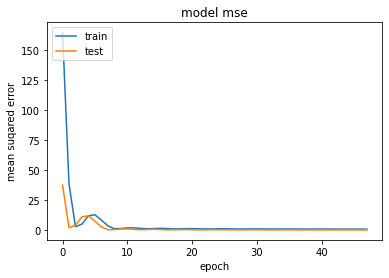

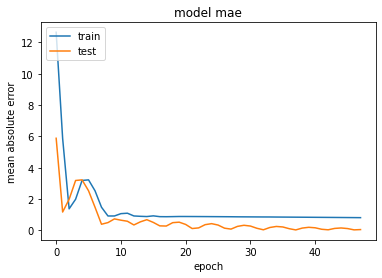

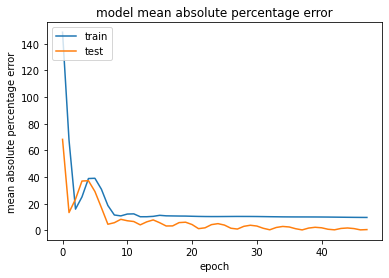

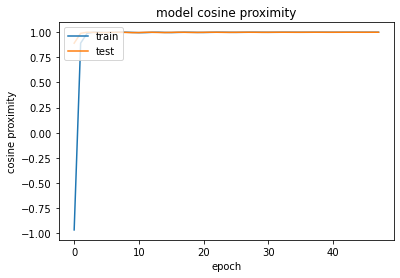

In [139]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[ 9 10]


array([[8.250594, 9.125049]], dtype=float32)

In [141]:
predictions = model.predict(X_test)
print(predictions)

[[8.053631 8.945402]]


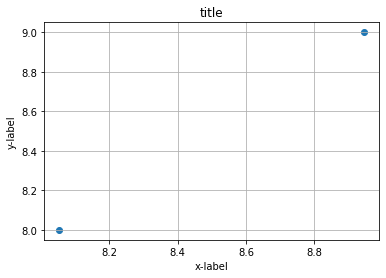

In [142]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()

# Real data

In [149]:
dataset = pd.read_csv('../data/Forecast Data/dataset.csv')
dataset['DATE'] = [datetime.strptime(date, '%Y-%m-%d') for date in dataset['DATE']]
dataset = dataset.set_index('DATE')

In [150]:
# Throw an exception when containing NaN values
if dataset.isnull().sum().sum() != 0:
    raise Exception("The dataset contains NaN values")

In [151]:
dataset

,Alte Pinakothek,Ausland (Tourismus),Olympiapark,Bayerisches Nationalmuseum,Bayerisches Staatsorchester,Deutsches Museum,Inland (Tourismus),Kleine Olympiahalle,Museum Brandhorst,Museum Mensch und Natur,...,Pinakothek der Moderne,Prinzregententheater,Residenztheater,Schackgalerie,Schauburg - Theater fuer junges Publikum,Staedtische Galerie im Lenbachhaus,Theater am Gaertnerplatz,Tierpark Hellabrunn,Kinos,AnzahlFall
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.022074,0.000000,0.054662,0.021952,0.002828,0.058816,0.00000,0.004381,0.000000,0.000000,...,0.000000,0.000000,0.017838,0.003648,0.003261,0.012083,0.018596,0.031459,0.528175,0.0
2000-02-01,0.016799,0.000000,0.046616,0.012995,0.000535,0.048220,0.00000,0.046616,0.000000,0.000000,...,0.000000,0.000000,0.016106,0.001261,0.003885,0.010910,0.015347,0.032155,0.403690,0.0
2000-03-01,0.022843,0.000000,0.005556,0.003271,0.003547,0.084640,0.00000,0.000256,0.000000,0.000000,...,0.000000,0.000000,0.016766,0.001139,0.003324,0.016486,0.016687,0.038560,0.347004,0.0
2000-04-01,0.012550,0.000000,0.001199,0.002616,0.003440,0.083873,0.00000,0.000599,0.000000,0.000000,...,0.000000,0.000000,0.011828,0.000610,0.002396,0.012647,0.013023,0.114267,0.310064,0.0
2000-05-01,0.020215,0.000000,0.001662,0.002130,0.000501,0.087256,0.00000,0.000427,0.000000,0.000000,...,0.000000,0.000000,0.013875,0.000557,0.005129,0.013359,0.017279,0.078731,0.288977,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,0.060554,0.176279,0.020328,0.019108,0.001141,0.070657,0.25623,0.000000,0.060554,0.033045,...,0.060554,0.034894,0.020034,0.000000,0.000866,0.008320,0.063272,0.021076,0.432509,1.0
2020-03-01,0.060034,0.000000,0.022493,0.028420,0.000000,0.122832,0.00000,0.000000,0.060034,0.042508,...,0.060034,0.052079,0.032594,0.000000,0.004643,0.029414,0.079618,0.083636,0.000000,23.0
2020-04-01,0.120421,0.000000,0.037304,0.036206,0.000000,0.124791,0.00000,0.000000,0.120421,0.061792,...,0.120421,0.063973,0.036206,0.000000,0.000000,0.000000,0.124791,0.027942,0.000000,3718.0


In [175]:
n_steps = 8
output_len = 4
dropNan = False
shuffle = True

In [176]:
X_Data, y_Data_comp = create_sequences(dataset, n_steps, output_len, dropNan)

In [177]:
y_Data.shape

(238, 4)

In [178]:
# Specify the wanted place
idx = 0
y_Data = y_Data_comp[:,:,idx]
y_Data.shape

(235, 4)

In [179]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)

In [180]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [181]:
n_feats = X_train.shape[2]
n_fore = y_Data.shape[1]
print(n_steps,n_feats,n_fore)

8 29 4


In [194]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=100,
    verbose=0,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 6, 50)             4400      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 4, 256)            38656     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 256)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 132       
Total params: 59,604
Trainable params: 59,604
Non-trainable params: 0
_________________________________________________

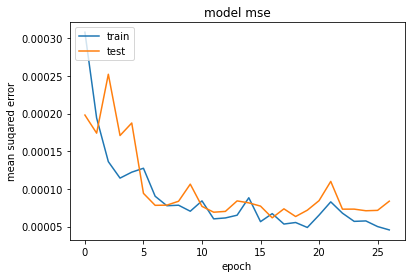

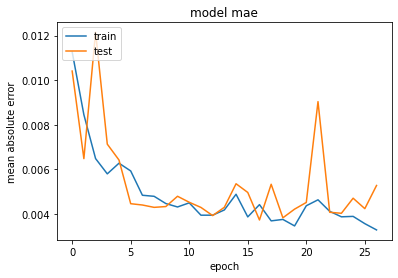

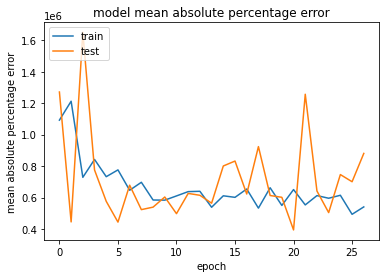

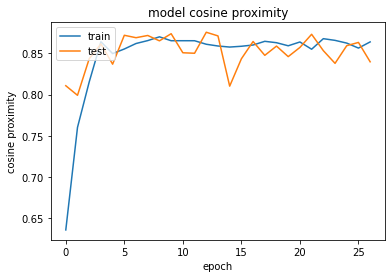

In [195]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [196]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[0.01695903 0.02023035 0.01633765 0.01666668]


array([[0.02240903, 0.01946029, 0.02488141, 0.02119153]], dtype=float32)

In [197]:
predictions = model.predict(X_test)
#print(predictions)

In [204]:
predictions.shape

(78, 4)

In [209]:
month = ["first", "second", "third", "fourth"]
month[0]

'first'

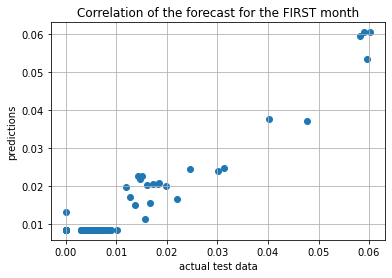

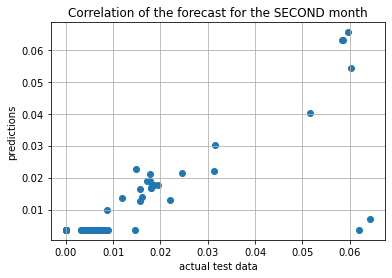

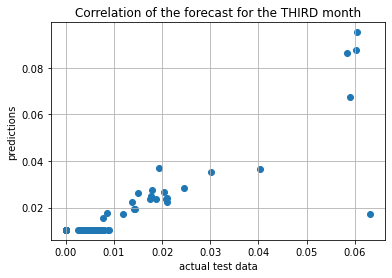

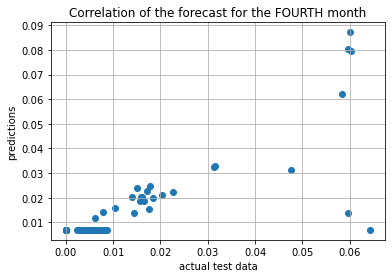

In [212]:
# Visualize the data
for i in np.arange(predictions.shape[1]):
    month = ["FIRST", "SECOND", "THIRD", "FOURTH"]
    fig = plt.figure()
    plt.scatter(y_test[:,i],predictions[:,i])
    plt.grid(True)
    plt.title("Correlation of the forecast for the "+month[i]+" month")
    plt.xlabel("actual test data")
    plt.ylabel("predictions")
    Figure = "../img/Forecast.png"
    fig.savefig(Figure)
    plt.show()
    mlflow.log_artifact(Figure)

In [219]:
# calculate Pearson's correlation
li = []
for i in np.arange(predictions.shape[1]):
    corr, _ = pearsonr(y_test[:,i],predictions[:,i])
    li.append(corr)
    print('Pearsons correlation for the',month[i],'month: %.3f' % corr)
# Calcuate the mean Pearson's correlation
corr_mean = np.mean(li)
print('Mean Pearsons correlation: %.3f' % corr_mean)
mlflow.log_param(, corr_mean)

Pearsons correlation for the FIRST month: 0.966
Pearsons correlation for the SECOND month: 0.805
Pearsons correlation for the THIRD month: 0.880
Pearsons correlation for the FOURTH month: 0.804
Mean Pearsons correlation: 0.864
